<a href="https://colab.research.google.com/github/andrew-okello/convolutional_neural_net/blob/main/convulational_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tutorial: Convolutional Neural Networks**




**Introduction**

In this practical we will cover the basics of convolutional neural networks, or "ConvNets". ConvNets were invented in the late 1980s/early 1990s, and have had tremendous success especially with vision (although they have also been used very successfully in speech processing pipelines, and more recently, for machine translation).



**Learning Objectives** 
* Be able to explain what a convolutional layer does and how it's different from a fully-connected layer
* Understand the assumptions and trade-offs that are being made when using convolutional architectures
* Be able to build a convolutional architecture using Tensorflow and Keras Layers
* Be able to use Keras to train a model on a dataset
* Implement a very small convolutional neural network

**Running on GPU**

For this practical, you will need to use a **GPU** to speed up training. To do this, go to the **"Runtime"** menu in Colab, select **"Change runtime type"** and then in the popup menu, choose "GPU" in the "Hardware accelelator" box. This is all you need to do, Colab and Tensorflow will take care of the rest! 
See gif below:

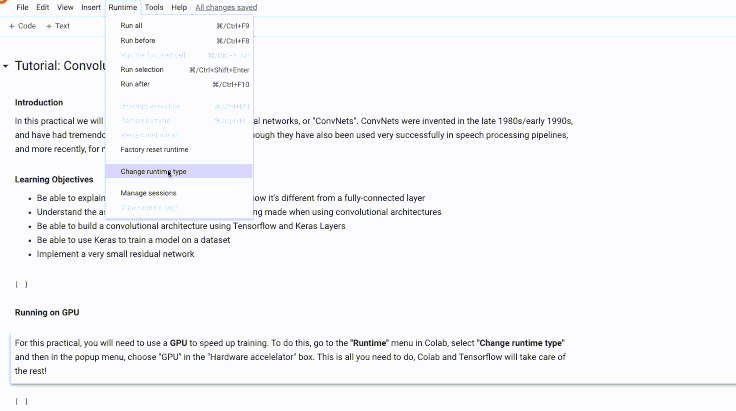

In [ ]:
# import the necessary libs

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


[Demo - **Open AI Microscope**: What Convnets "**see**"](https://microscope.openai.com/models/alexnet?models.caricature.cossim_pow=2.0&models.caricature.image=cat&models.technique=caricature)

# Part 1: Convolutional Architectures

When modelling an image using a regular feed-forward network, we find that the number of model parameters grows exponentially. For example, the tiny network we built in Practical 1 already had over 100,000 parameters!



**QUESTION**: How many parameters would there be in a feed-forward network with 2 hidden layers consisting of 512 and 256 neurons respectively, an output size of 10 and an input image of shape [32, 32, 3]? (Note that we represent each pixel in a a colour image using three real-numbers for the Red, Green and Blue values -- called "channels" -- and hence the 32x32x3 shape.)

## **Convolutional Layers** 


A convolutional layer maps an input volume (meaning, a 3-D input tensor, e.g. [width, height, channels]) to an output volume through a set of learnable filters, which make up the parameters of the layer. Every filter is small spatially (along width and height), but extends through the full depth of the input volume. (Eg: A filter in the first layer of a ConvNet might have size [5, 5, 3]). 

During the forward pass, we convolve ("slide") each filter across the width and height of the input volume and compute element-wise dot products between the entries of the filter and the input at any position. As we slide the filter over the width and height of the input volume we will produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. Each convolutional layer will have such a set of filters, and each of them will produce a separate 2-dimensional activation map. We then stack these activation maps along the depth-dimension to produce the output volume.

By using these filters which map to a small sub-volume of the input, we can to a large extent,control the parameter explosion that we would get with a (fully-connected) feed-forward network. This parameter sharing actually also tends to improve the performance of the model on inputs like natural images because it provides the model with some limited translation invariance. Translation invariance means that if the image (or a feature in the image) is translated (moved), the model will not be significantly affected. Think about why this is the case!

The following animation illustrates these ideas, make sure you understand them!

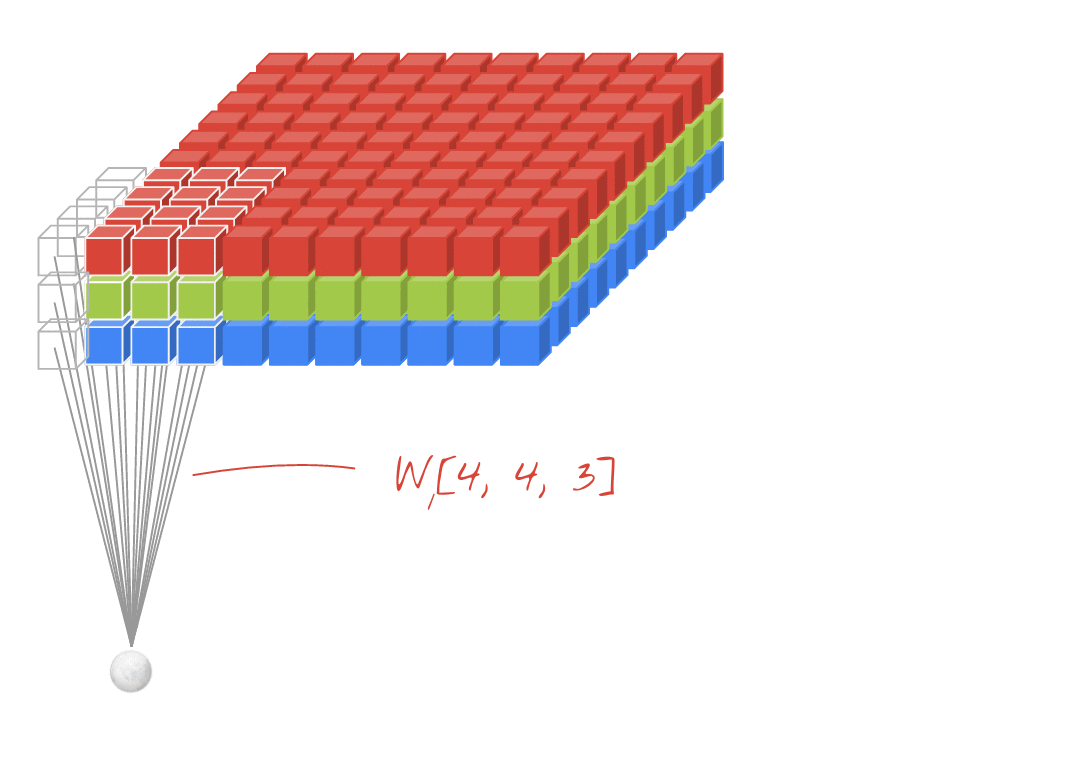

The hyper parametrs of a convolutional layer are as follows:


*   **Filters** defines the number of filters in the layer
*   **Kernel Size** defines the width and height of the filters (also called "kernels") in the layer. Note that kernels always have the same depth as the inputs to the layer.
*   **Stride** defines the number of pixels by which we move the filter when "sliding" it along the input volume. Typically this value would be 1, but values of 2 and 3 are also sometimes used.
*   **Padding** refers to the addition of 0-value pixels to the edges of the input volume along the width and height dimensions. In Tensorflow you can set this to "VALID", which essentially does no padding or "SAME" which pads the input such that the output width and height are the same as the input.




Lets look at a very simple, dummy example to see how the values of the hyper-parameters affect the output size of a convolutional layer.


Input shape: (10, 10, 3)


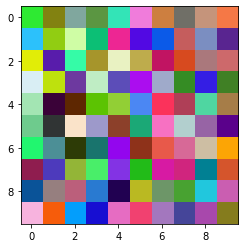

In [ ]:
# Create a random colour "image" of shape 10x10 with a depth of 3 (for red, green and blue)
import numpy as np
dummy_input = np.random.uniform(size=[10, 10, 3])
fig, ax = plt.subplots(1, 1)
plt.imshow(dummy_input)
ax.grid(False)
print('Input shape: {}'.format(dummy_input.shape))

Now adjust the hyperparameters using the sliders on the right and see how the output shape changes for a [10, 10, 3] input.


In [ ]:
#@title Convolutional layer parameters {run: "auto"}
filters = 3  #@param { type: "slider", min:0, max: 10, step: 1 }
kernel_size = 6 #@param { type: "slider", min:1, max: 10, step: 1 }
stride = 3 #@param { type: "slider", min:1, max: 3, step: 1 }

conv_layer = tf.keras.layers.Conv2D(
    filters=filters, 
    kernel_size=kernel_size, 
    strides=stride,
    padding="valid",
    input_shape=[10, 10, 3])

# Convert the image to a tensor and add an extra batch dimension which
# the convolutional layer expects.
input_tensor = tf.convert_to_tensor(dummy_input[None, :, :, :])
convoluted = conv_layer(input_tensor)

print('The output dimension is:')


list([d for d in convoluted.shape])[1:]

The output dimension is:


[2, 2, 3]

## **(Max) Pooling**

A pooling layer reduces the spatial size of the representation. There are different reasons why we may want to do this. One is to reduce the number of parameters in the network. Imagine a convnet for the MNIST dataset. If the feature tensor produced by the final conv/pool/relu layer was say, of size `20x20` and had 100 feature channels, the final dense layer would have 2020100*10=400k parameters. However if we down-sampled that layer to a 4x4 spatial size, we would have only 20k parameters. A big difference!



---



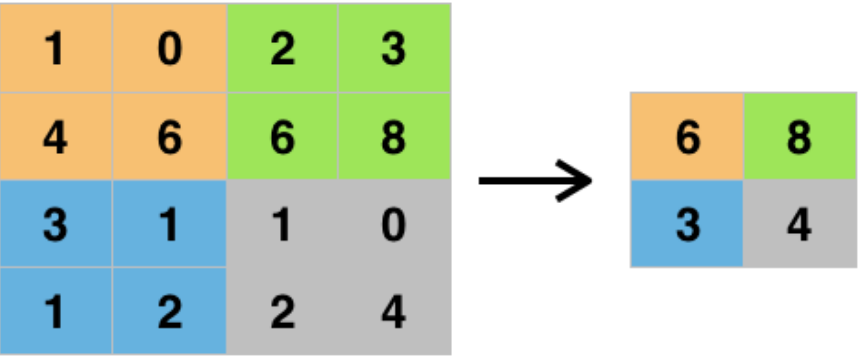

Another reason is that we want later features (deeper int he network) to have larger receptive fields (input regions that they look at), in order to represent bigger objects and object parts for instance. In particular, pooling stride gives later features much larger receptive fields so that they can effectively combine smaller features together.

A pooling layer has no trainable parameters itself. It applies some 2-D aggegation operation (usually a `max()`, but others like `average()` may also be used) to regions of the input volume. This is done independently for each depth dimension of the input. 

For example, a 2x2 max pooling operation with a stride of 2, downsamples every depth slice of the input by 2 along both the width and height.

## **In code**

In [ ]:
import keras
from keras_preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, Activation
from keras.optimizers  import RMSprop, SGD, Adam
from keras.losses import sparse_categorical_crossentropy
import matplotlib.pyplot as plt
import numpy as np
import os
from keras import models
import cv2


**The CIFAR10 Dataset**

Now that we understand convolutional, max-pooling and feed-forward layers, we can combine these as building block to build a ConvNet classifier for images. For this practical, we will use the colour image dataset CIFAR10 (pronounced "seefar ten") which consists of 50,000 training images and 10,000 test images. we take 10,000 images from the training set to form a validation set and visualise some example image

In [ ]:
cifar = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
# Take the last 10000 images from the training set to form a validation set 
train_labels = train_labels.squeeze()
validation_images = train_images[-10000:, :, :]
validation_labels = train_labels[-10000:]
train_images = train_images[:-10000, :, :]
train_labels = train_labels[:-10000]

In [ ]:
print('train_images.shape = {}, data-type = {}'.format(train_images.shape, train_images.dtype))
print('train_labels.shape = {}, data-type = {}'.format(train_labels.shape, train_labels.dtype))

print('validation_images.shape = {}, data-type = {}'.format(validation_images.shape, validation_images.dtype))
print('validation_labels.shape = {}, data-type = {}'.format(validation_labels.shape, validation_labels.dtype))

train_images.shape = (40000, 32, 32, 3), data-type = uint8
train_labels.shape = (40000,), data-type = uint8
validation_images.shape = (10000, 32, 32, 3), data-type = uint8
validation_labels.shape = (10000,), data-type = uint8


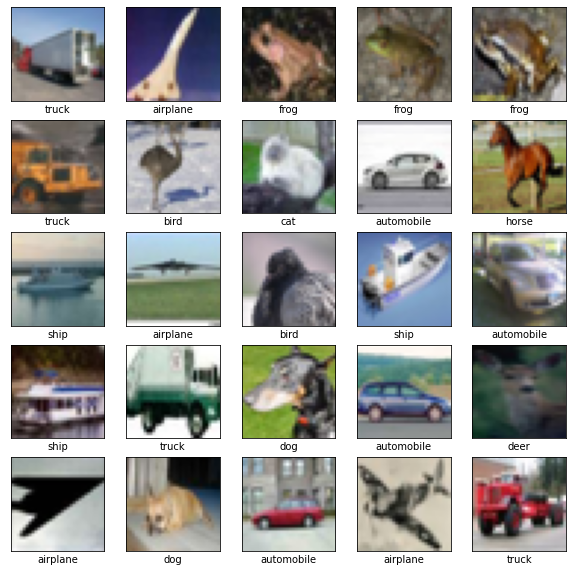

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  img_index = np.random.randint(0, 40000)
  plt.imshow(train_images[img_index])
  plt.xlabel(cifar_labels[train_labels[img_index]])

### **A ConvNet Classifier**

Finally, we build a simple convolutional architecture to classify the CIFAR images. We will build a mini version of the AlexNet architecture, which consists of 5 convolutional layers with max-pooling, followed by 3 fully-connected layers at the end. In order to investigate the effect each of these two layers have on the number of parameters, we'll build the model in two stages.

First, the convolutional layers + max-pooling:

In [ ]:
# Define the convolutinal part of the model architecture using Keras Layers.
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
])

How many parameters are there in the convolutional part of the architecture? We can easily inspect this using the model summary function in Keras:



In [ ]:
## How many params in deep model?
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       55424     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 192)         221376    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 192)         331968    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 128)         2

Now we add a fully-connected part. Note that we also add "Dropout" after the first fully-connected layer. Dropout is a regularization technique which randomly zeros out ("drops") connections between neurons, and it was one of the key innovations of the AlexNet paper in 2012.



In [ ]:
model.add(tf.keras.layers.Flatten())  # Flatten "squeezes" a 3-D volume down into a single vector.
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       55424     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 192)         221376    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 192)         331968    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 128)         2

Training and Validating the model
In the last practical we wrote out the dataset pipeline, loss function and training-loop to give you a good appreciation for how it works. This time, we use the training loop built-in to Keras. For simple, standard datasets like CIFAR, doing it this way will work fine, but it's important to know what goes on under the hood because you may need to write some or all of the steps out manually when working with more complex datasets!

In [ ]:
batch_size = 35
num_epochs = 25  # The number of epochs (full passes through the data) to train for

# Compiling the model adds a loss function, optimiser and metrics to track during training
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
# The fit function allows you to fit the compiled model to some training data
history = model.fit(x=train_images, 
          y=train_labels, 
          batch_size=batch_size, 
          epochs=num_epochs, 
          validation_data=(validation_images, validation_labels.astype(np.float32)))

print('Training complete')

Epoch 1/25
 437/1143 [==========>...................] - ETA: 1:42 - loss: 1.9216 - accuracy: 0.2947

KeyboardInterrupt: ignored

In [ ]:
# Loss Curves
def plot_curves(history):
  plt.figure(figsize=[14,10])
  plt.subplot(211)
  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
  
  # Accuracy Curves
  plt.figure(figsize=[14,10])
  plt.subplot(212)
  plt.plot(history.history['accuracy'],'r',linewidth=3.0)
  plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

In [ ]:
plot_curves(history)

**Test the Model Performance**

In [ ]:
metric_values = model.evaluate(x=test_images, y=test_labels)

print('Final TEST performance')
for metric_value, metric_name in zip(metric_values, model.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))

In [ ]:
img_indices = np.random.randint(0, len(test_images), size=[25])
sample_test_images = test_images[img_indices]
sample_test_labels = [cifar_labels[i] for i in test_labels[img_indices].squeeze()]

predictions = model.predict(sample_test_images)
max_prediction = np.argmax(predictions, axis=1)
prediction_probs = np.max(predictions, axis=1)

In [ ]:
plt.figure(figsize=(10,10))
for i, (img, prediction, prob, true_label) in enumerate(
    zip(sample_test_images, max_prediction, prediction_probs, sample_test_labels)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  plt.imshow(img)
  plt.xlabel('{} ({:0.3f})'.format(cifar_labels[prediction], prob))
  plt.ylabel('{}'.format(true_label))

# **Extensions to Improve Performance**

Below are some ideas that you can try to extend upon the models and improve model performance.



*  **Train for More Epochs**. Each model was trained for a very small number of epochs, 25. It is common to train large convolutional neural networks for hundreds or thousands of epochs. I would expect that performance gains can be achieved by significantly raising the number of training epochs.
*   **Image Data Augmentation**. The objects in the image vary in their position. Another boost in model performance can likely be achieved by using some data augmentation. Methods such as standardization and random shifts and horizontal image flips may be beneficial.

* **Deeper Network Topology**. The larger network presented is deep, but larger networks could be designed for the problem. This may involve more feature maps closer to the input and perhaps less aggressive pooling. Additionally, standard convolutional network topologies that have been shown useful may be adopted and evaluated on the problem

* **Transfer learning**: The basic premise of transfer learning is simple: take a model trained on a large dataset and transfer its knowledge to a smaller dataset. 

**Adding dropout to reduce overfitting**


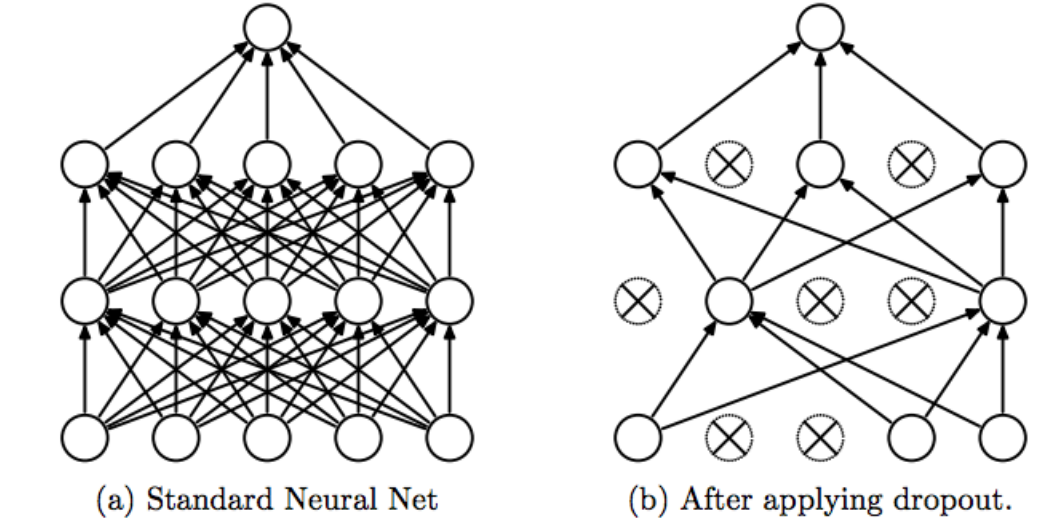

**Dropout** is a regularization technique for reducing overfitting in artificial neural networks by preventing complex co-adaptations on training data. 

It is an efficient way of performing model averaging with neural networks. The term dropout refers to randomly "***dropping out***", or omitting, units (both hidden and visible) during the training process of a neural network. 


In [ ]:
# Define the convolutinal part of the model architecture and using Dropout Layers.
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Dropout(0.3),


    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.4),

])


model2.add(tf.keras.layers.Flatten())

model2.add(tf.keras.layers.Dropout(rate=0.5))
model2.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))
# model = Sequential()

# compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model2.summary()


In [ ]:
batch_size = 35
num_epochs = 25  # The number of epochs (full passes through the data) to train for

# Compiling the model adds a loss function, optimiser and metrics to track during training
model2.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
# The fit function allows you to fit the compiled model to some training data
history2 = model2.fit(x=train_images, 
          y=train_labels, 
          batch_size=batch_size, 
          epochs=num_epochs, 
          validation_data=(validation_images, validation_labels.astype(np.float32)))

print('Training complete')

In [ ]:
metric_values = model2.evaluate(x=test_images, y=test_labels)

print('Final TEST performance')
for metric_value, metric_name in zip(metric_values, model2.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))

In [ ]:
plot_curves(history2)

### BatchNorm + Augmentation + Dropout

In [ ]:
# Define the convolutinal part of the model architecture using Keras Layers.
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
 
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Dropout(0.3),


    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.4),

])


model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Dropout(rate=0.5))
model3.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))
# model = Sequential()

# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train = datagen.flow(train_images, train_labels, batch_size=64)

batch_size = 35
num_epochs = 25  # The number of epochs (full passes through the data) to train for

# Compiling the model adds a loss function, optimiser and metrics to track during training
model3.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
# The fit function allows you to fit the compiled model to some training data
history3 = model3.fit_generator(it_train,
          epochs=num_epochs,
          validation_data=(validation_images, validation_labels.astype(np.float32)))

print('Training complete')

In [ ]:
plot_curves(history3)

In [ ]:
metric_values = model3.evaluate(x=test_images, y=test_labels)

print('Final TEST performance')
for metric_value, metric_name in zip(metric_values, model3.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))

## Take Aways

*   Created a simple convolutional neural net
*   Improved performance by tackling overfitting
*   Implemented dropout layers

## Your Tasks



1.  [ALL] Experiment with the network architecture, try changing the 
numbers, types and sizes of layers, the sizes of filters, using different padding etc. How do these decisions affect the performance of the model? In particular, try building a fully convolutinoal network, with no (max-)pooling layers.


2.  [ADVANCED] Read about Residual networks ( [original paper](https://https://arxiv.org/abs/1512.03385), ) and add shortcut connections to the model architecture. Try to build a simple reusable "**residual block**" as a Keras Model.
